# Régression linéaire multiple

1. Corrigé du quizz
2. Recap
3. Régressions multiples

On se place dans le même contexte que précédemment, simplement on utilise plusieurs variables explicatives.

Matriciellement on se retrouve avec la configuration suivante : 

$$
\mathbf{y} = \mathbf{X}\boldsymbol{\beta} + \boldsymbol{\varepsilon}, \quad
\hat{\boldsymbol{\beta}} = (\mathbf{X}^\top \mathbf{X})^{-1} \mathbf{X}^\top \mathbf{y}
$$

$$
\mathbf{y} = (y_1, \dots, y_n)^\top, \quad
\mathbf{X} = 
\begin{bmatrix} 
1 & x_{11} & \dots & x_{1p} \\ 
\vdots & \vdots & \ddots & \vdots \\ 
1 & x_{n1} & \dots & x_{np} 
\end{bmatrix}, \quad
\boldsymbol{\beta} = (\beta_0, \dots, \beta_p)^\top, \quad
\boldsymbol{\varepsilon} = (\varepsilon_1, \dots, \varepsilon_n)^\top
$$



## Génération d'un jeu de données

In [15]:
import numpy as np 
import matplotlib.pyplot as plt
from utils import generate_regression_data
import plotly.graph_objects as go

X, y, _ = generate_regression_data(n_samples=50, n_features=2, noise_std=1)

fig = go.Figure(data=[go.Scatter3d(
    x=X[:,0], 
    y=X[:,1], 
    z=y,      
    mode='markers',
    marker=dict(
        size=5,
        color=y,    # couleur selon y
        colorscale='Viridis',
        opacity=0.8
    )
)])

fig.update_layout(
    scene=dict(
        xaxis_title='âge du consommateur',
        yaxis_title='salaire',
        zaxis_title='CA'
    ),
    title='Jeu de données à trois dimensions'
)

fig.show()


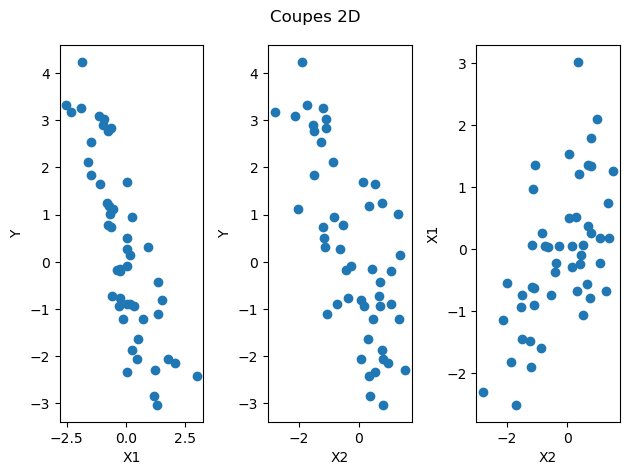

In [2]:
fig, axs = plt.subplots(1, 3)

axs[0].scatter(X[:, 0], y)
axs[0].set_xlabel("X1")
axs[0].set_ylabel("Y")
axs[1].scatter(X[:, 1], y)
axs[1].set_xlabel("X2")
axs[1].set_ylabel("Y")
axs[2].scatter(X[:, 1], X[:, 0])
axs[2].set_xlabel("X2")
axs[2].set_ylabel("X1")
plt.suptitle("Coupes 2D")
plt.tight_layout()
plt.show();

## Régression linéaire multivariée


De la même manière que pour la régression simple, on cherche à minimiser la fonction d'erreur. Comme le jeu de données est petit, on va résoudre le problème algébraiquement. 

La solution est données par : 

$
\hat{\boldsymbol{\beta}} = (\mathbf{X}^\top \mathbf{X})^{-1} \mathbf{X}^\top \mathbf{y}
$

Un détour par l'algèbre linéaire

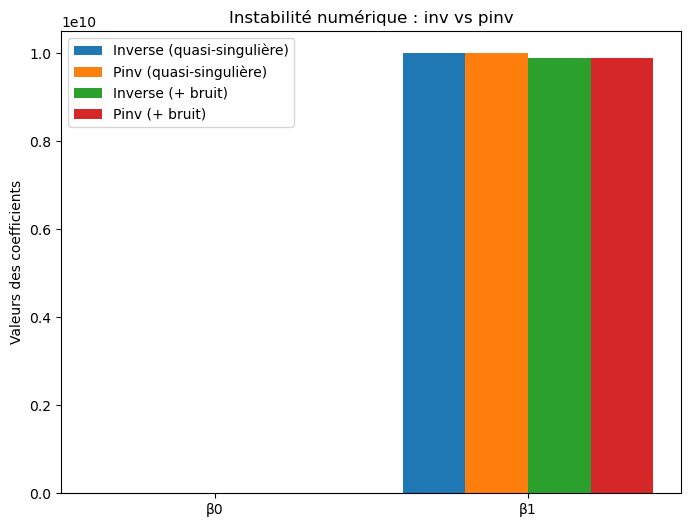

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Matrice quasi-singulière
X = np.array([[1, 0], [1, 1e-10]])
y = np.array([1, 2])  # un petit vecteur

# Avec inverse classique
beta_inv = np.linalg.inv(X) @ y

# Avec pseudo-inverse
beta_pinv = np.linalg.pinv(X) @ y

# Avec une petite perturbation (bruit)
eps = 1e-12
X_noisy = X + np.array([[0, 0], [0, eps]])
beta_inv_noisy = np.linalg.inv(X_noisy) @ y
beta_pinv_noisy = np.linalg.pinv(X_noisy) @ y

# Comparaison visuelle des coefficients
labels = ["β0", "β1"]
x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots(figsize=(8,6))

ax.bar(x - width, beta_inv, width, label="Inverse (quasi-singulière)")
ax.bar(x, beta_pinv, width, label="Pinv (quasi-singulière)")
ax.bar(x + width, beta_inv_noisy, width, label="Inverse (+ bruit)")
ax.bar(x + 2*width, beta_pinv_noisy, width, label="Pinv (+ bruit)")

ax.set_xticks(x + width/2)
ax.set_xticklabels(labels)
ax.set_ylabel("Valeurs des coefficients")
ax.set_title("Instabilité numérique : inv vs pinv")
ax.legend()
plt.show()


In [14]:
def algebraic_resolution(X, y, fit_intercept=True):
    """
    Résout le problème des moindres carrés pour une régression linéaire multiple.

    Paramètres
    ----------
    X : numpy.ndarray, shape (n_samples, n_features)
        Matrice des variables explicatives
    y : numpy.ndarray, shape (n_samples,) ou (n_samples, 1)
        Vecteur cible
    fit_intercept : bool, default=True
        Ajouter ou non un intercept (colonne de 1)

    Retour
    ------
    parameters : numpy.ndarray
        Coefficients estimés (intercept + beta si fit_intercept=True)
    """
    X = np.array(X)
    y = np.array(y).reshape(-1, 1)

    if fit_intercept:
        # Ajouter une colonne de 1 pour l'intercept
        X = np.hstack([np.ones((X.shape[0], 1)), X])
    
    # Résolution analytique : beta = (X^T X)^(-1) X^T y
    XtX = X.T @ X
    Xty = X.T @ y
    beta = np.linalg.pinv(XtX) @ Xty  # pseudo-inverse pour la stabilité

    return beta.flatten()

coef = algebraic_resolution(X, y, fit_intercept=True)
coef

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 50 is different from 2)

In [36]:
import numpy as np
import plotly.graph_objects as go

# Création d'une grille pour le plan
x1_range = np.linspace(X[:,0].min(), X[:,0].max(), 20)
x2_range = np.linspace(X[:,1].min(), X[:,1].max(), 20)
x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)
y_grid = coef[0] + coef[1]*x1_grid + coef[2]*x2_grid

# Scatter des points
scatter = go.Scatter3d(
    x=X[:,0],
    y=X[:,1],
    z=y,
    mode='markers',
    marker=dict(size=5, color='blue', opacity=0.8),
    name='Données'
)

# Plan de régression
surface = go.Surface(
    x=x1_grid,
    y=x2_grid,
    z=y_grid,
    colorscale='Viridis',
    opacity=0.6,
    name='Plan de régression'
)

# Figure
fig = go.Figure(data=[scatter, surface])
fig.update_layout(
    scene=dict(
        xaxis_title='X[:, 0]',
        yaxis_title='X[:, 1]',
        zaxis_title='y'
    ),
    title='Régression linéaire multiple 3D'
)
fig.show()


## Comment lire les paramètres d'une régression linéaire multiple ? 

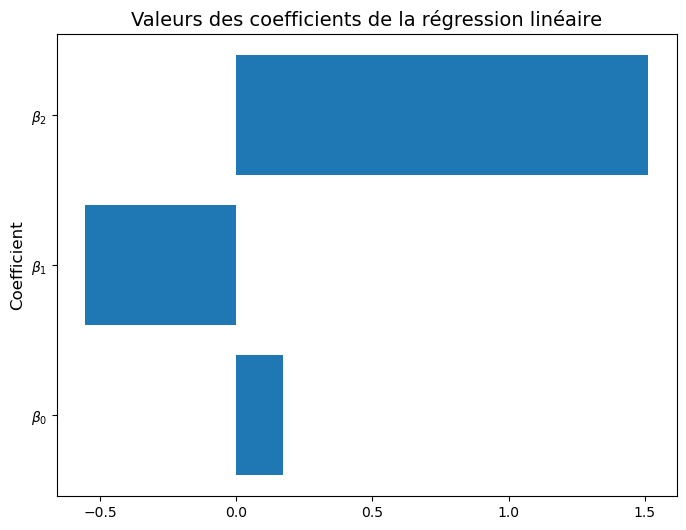

In [37]:
labels = [r'$\beta_0$', r'$\beta_1$', r'$\beta_2$']

# Création de l'histogramme
plt.figure(figsize=(8,6))
plt.barh(labels, coef)

plt.title('Valeurs des coefficients de la régression linéaire', fontsize=14)
plt.ylabel('Coefficient', fontsize=12)
plt.show()

In [38]:
from ipywidgets import interact
import matplotlib.pyplot as plt
import numpy as np

# Limites fixes
x0_min, x0_max = X[:,0].min(), X[:,0].max()
x1_min, x1_max = X[:,1].min(), X[:,1].max()
y_min, y_max = y.min(), y.max()

def plot_three_views(B0=0, B1=1, B2=1):
    fig = plt.figure(figsize=(18,5))
    
    # Création des grilles pour les 2D
    x0_grid_1d = np.linspace(x0_min, x0_max, 100)
    x1_grid_1d = np.linspace(x1_min, x1_max, 100)
    
    # ---- 2D X1 vs y ----
    ax1 = fig.add_subplot(1,3,1)
    ax1.scatter(X[:,0], y, color='blue')
    # On fixe X2 à sa moyenne pour la prédiction
    y_pred_x1 = B0 + B1*x0_grid_1d + B2*X[:,1].mean()
    ax1.plot(x0_grid_1d, y_pred_x1, color='orange')
    ax1.set_xlabel('X[:,0]')
    ax1.set_ylabel('y')
    ax1.set_title('X1 vs y')
    ax1.set_xlim(x0_min, x0_max)
    ax1.set_ylim(y_min, y_max)
    
    # ---- 2D X2 vs y ----
    ax2 = fig.add_subplot(1,3,2)
    ax2.scatter(X[:,1], y, color='blue')
    # On fixe X1 à sa moyenne pour la prédiction
    y_pred_x2 = B0 + B1*X[:,0].mean() + B2*x1_grid_1d
    ax2.plot(x1_grid_1d, y_pred_x2, color='orange')
    ax2.set_xlabel('X[:,1]')
    ax2.set_ylabel('y')
    ax2.set_title('X2 vs y')
    ax2.set_xlim(x1_min, x1_max)
    ax2.set_ylim(y_min, y_max)
    
    # ---- 3D ----
    ax3 = fig.add_subplot(1,3,3, projection='3d')
    ax3.scatter(X[:,0], X[:,1], y, color='blue')
    
    x0_range = np.linspace(x0_min, x0_max, 20)
    x1_range = np.linspace(x1_min, x1_max, 20)
    x0_grid, x1_grid = np.meshgrid(x0_range, x1_range)
    y_grid = B0 + B1*x0_grid + B2*x1_grid
    ax3.plot_surface(x0_grid, x1_grid, y_grid, color='orange', alpha=0.5)
    
    ax3.set_xlabel('X[:,0]')
    ax3.set_ylabel('X[:,1]')
    ax3.set_zlabel('y')
    ax3.set_title('3D plan de régression')
    ax3.set_xlim(x0_min, x0_max)
    ax3.set_ylim(x1_min, x1_max)
    ax3.set_zlim(y_min, y_max)
    
    plt.tight_layout()
    plt.show()

interact(plot_three_views,
         B0=(-10, 10, 0.1),
         B1=(-5, 5, 0.1),
         B2=(-5, 5, 0.1));


interactive(children=(FloatSlider(value=0.0, description='B0', max=10.0, min=-10.0), FloatSlider(value=1.0, de…

Le plot précédent nous permet d'illustrer le concept de dépendence conditionnelle : une augmentation d'une unité de X2 est associée à une augmentation de beta_2 de y2 **toutes choses étant égales par ailleurs**.


D'autre part, il ne faut pas confondre corrélation et causalité :
<p align="center">
  <img src="./img/chocolate_vs_nobel_prize.png" alt="plot" width="50%"/>
</p>

Il s'agit d'un lien de corrélation trouvé dans les données, pas d'un lien causal.

# De l'importance du scaling pour pouvoir comparer les coefficients

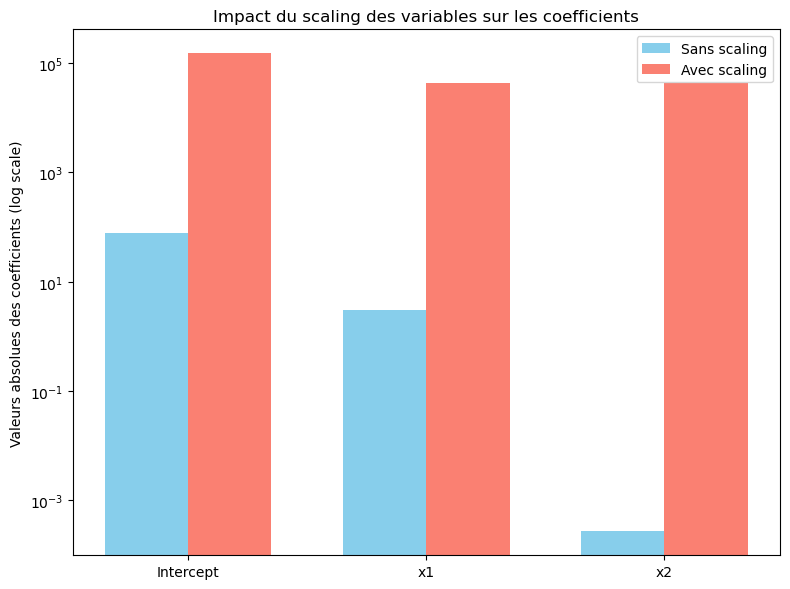

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# --- Génération de données ---
np.random.seed(42)
n_samples = 50

x1 = np.linspace(1e3, 1e5, n_samples)       # grande échelle
x2 = np.linspace(1, 10, n_samples)         # petite échelle
noise = np.random.normal(0, 1e3, n_samples)

y = 3 * x1 + 2 * x2 + 5 + noise
X = np.vstack([x1, x2]).T

# --- Modèle sans scaling ---
model_raw = LinearRegression()
model_raw.fit(X, y)
coef_raw = np.hstack([model_raw.intercept_, model_raw.coef_])

# --- Modèle avec scaling ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model_scaled = LinearRegression()
model_scaled.fit(X_scaled, y)
coef_scaled = np.hstack([model_scaled.intercept_, model_scaled.coef_])

# --- Plot comparatif ---
labels = ["Intercept", "x1", "x2"]
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x - width/2, np.abs(coef_raw), width, label="Sans scaling", color='skyblue')
ax.bar(x + width/2, np.abs(coef_scaled), width, label="Avec scaling", color='salmon')

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel("Valeurs absolues des coefficients (log scale)")
ax.set_yscale("log")  # <-- log scale
ax.set_title("Impact du scaling des variables sur les coefficients")
ax.legend()
plt.tight_layout()
plt.show()


# Limitations du modèle de régressions linéaires multiples

- ne gère que les relations linéaires (assez évident ...)
- plus difficile à visualiser
- risque de sur-apprentissage
- multicolinéarité

- Génération & viz du jeu de données avec 2 variables 
- Descente de gradient et plan de régression
- Jeu de données avec 5 variables
- pros & cons
- problème de multicoloniératité
- lasso et ridge
- variable quantitative et qualitative (one hot et ordinal)

### Ridge regression

$$
\hat{\beta}^{\text{ridge}} 
= \underset{\beta}{\arg\min} \; 
\left\{ 
\| y - X\beta \|_2^2 + \lambda \| \beta \|_2^2 
\right\}
$$

avec 

$$
\| \beta \|_2^2 = \sum_{j=1}^p \beta_j^2
$$

---

### Lasso regression

$$
\hat{\beta}^{\text{lasso}} 
= \underset{\beta}{\arg\min} \; 
\left\{ 
\| y - X\beta \|_2^2 + \lambda \| \beta \|_1 
\right\}
$$

avec 

$$
\| \beta \|_1 = \sum_{j=1}^p |\beta_j|
$$


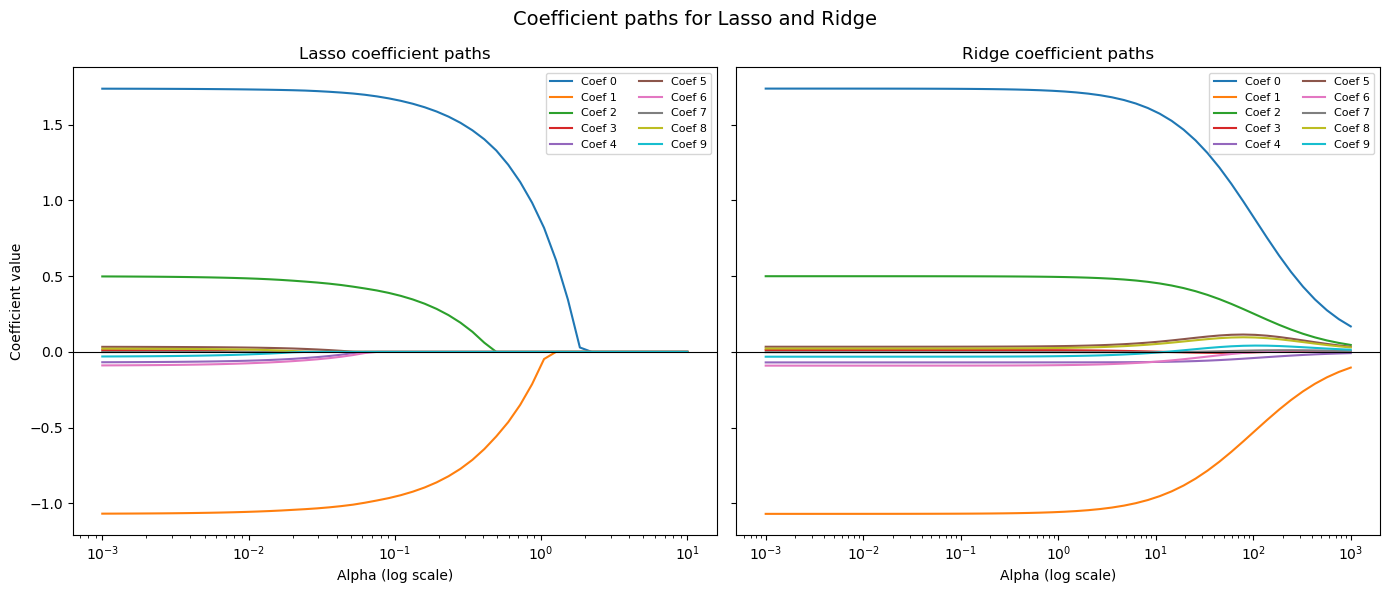

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import lasso_path, ridge_regression
from sklearn.preprocessing import StandardScaler

# --- Génération de données synthétiques ---
np.random.seed(42)
n_samples, n_features = 100, 10
X = np.random.randn(n_samples, n_features)
coef_true = np.zeros(n_features)
coef_true[0:3] = [2, -1, 0.5]  # seules 3 variables sont utiles
y = X @ coef_true + np.random.normal(0, 0.5, n_samples)

# Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Lasso paths ---
alphas_lasso, coefs_lasso, _ = lasso_path(X_scaled, y, alphas=np.logspace(-3, 1, 50))

# --- Ridge paths ---
alphas_ridge = np.logspace(-3, 3, 50)
coefs_ridge = []
for a in alphas_ridge:
    coef = ridge_regression(X_scaled, y, alpha=a)
    coefs_ridge.append(coef)
coefs_ridge = np.array(coefs_ridge).T  # shape (n_features, n_alphas)

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=True)

# Lasso
for i in range(coefs_lasso.shape[0]):
    axes[0].plot(alphas_lasso, coefs_lasso[i], label=f'Coef {i}')
axes[0].set_xscale("log")
axes[0].set_xlabel("Alpha (log scale)")
axes[0].set_ylabel("Coefficient value")
axes[0].set_title("Lasso coefficient paths")
axes[0].axhline(0, color='black', linewidth=0.8)
axes[0].legend(ncol=2, fontsize=8)

# Ridge
for i in range(coefs_ridge.shape[0]):
    axes[1].plot(alphas_ridge, coefs_ridge[i], label=f'Coef {i}')
axes[1].set_xscale("log")
axes[1].set_xlabel("Alpha (log scale)")
axes[1].set_title("Ridge coefficient paths")
axes[1].axhline(0, color='black', linewidth=0.8)
axes[1].legend(ncol=2, fontsize=8)

plt.suptitle("Coefficient paths for Lasso and Ridge", fontsize=14)
plt.tight_layout()
plt.show()


<p align="center">
  <img src="./img/lasso_ridge_path.png" alt="plot" width="50%"/>
</p>

# PCA / Variables qualitatives

## Ressources : 

- [Common pitfalls in interpreting linear regression coefficients](https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html), documentation scikit-learn